In a previous post, we looked at how to discretize conservation laws using the discontinuous Galerkin method.
The DG method, with an appropriate choice of numerical flux and limiting scheme, can be a great way to solve purely hyperbolic problems.
But many realistic problems aren't purely hyperbolic -- there's diffusive transport as well:

$$\frac{\partial\phi}{\partial t} + \nabla\cdot \phi u = \nabla\cdot k\nabla \phi.$$

where $\phi$ is the solution, $u$ is a velocity field, and $k$ is the conductivity.
Depending on the ratio $UL / k$, where $L$ is a characteristic length scale, the problem is either advection- or diffusion-dominated.

What basis functions should we use for a problem with mixed character like convection-diffusion?
It might seem that we have only bad choices.
We could use continuous basis functions, which makes the diffusive part of the equation easy, but we might then need to stabilize the advective part using, say, streamlined upwinding.
DG methods work perfectly well for discretizing the advection operator, but it feels a little strange to use basis functions that don't even live in the same function space as the solution.
Nonetheless, it is possible to use DG for elliptic problems and we've already seen how in the form of Nitsche's method.

### DG for elliptic problems

Recall that Nitsche's method gave us a way to weakly impose Dirichlet boundary conditions for elliptic PDE by modifying the variational principle rather than the discretized linear system.
In the post where I introduced Nitsche's method, the application was for Dirichlet conditions at the boundary $\partial\Omega$ of the domain $\Omega$.
To arrive at a DG discretization of elliptic problems, we'll instead imagine **using Nitsche's method on every cell of the mesh**.
Rather than impose a set value on the boundary of each cell, we'll instead use Nitsche's method to penalize discontinuous solutions.
For this reason the method that I'll describe is called the symmetric interior-penalty discontinuous Galerkin method.

Let's suppose we were only interested in solving the variational problem to minimize

$$J(\phi) = \frac{1}{2}\int_\Omega k|\nabla\phi|^2dx$$

subject to the boundary condition $\phi|_{\partial\Omega} = g$.
This is another way of stating the weak form of the elliptic part of our problem above.
Rather than enforce the Dirichlet boundary condition at the level of the discretized linear system, as is customary, we could instead use a different action functional:

$$J(\phi) = \frac{1}{2}\int_\Omega k|\nabla \phi|^2dx - \int_{\partial\Omega}k\frac{\partial \phi}{\partial n}(\phi - g)\,ds + \sum_E\int_E\frac{\gamma k}{2h}|\phi - g|^2ds,$$

where $E$ are all of the boundary faces of the mesh, $h$ the diameter of $E$, and $\gamma$ a constant.
Let $\theta$ be the smallest angle between any two edges of the mesh, $d$ the spatial dimension, and $p$ the polynomial degree of the finite element basis.
In the post on Nitsche's method, we showed that if

$$\gamma > 2 \cdot p \cdot (p + d - 1) \cdot \csc\theta\cdot\cot\theta / 2\cdot\frac{\max k}{\min k}$$

the modified action functional is convex and we can be assured that there is a discrete solution.
The advantage of Nitsche's method is that we don't have to modify the discretized linear system, which can be error-prone, and that we can compute a good value of $\gamma$ just by examining the mesh and conductivity coefficient.

The idea behind DG discretization of elliptic problems is that, instead of using Nitsche's method to enforce a Dirichlet condition at the boundary of the whole domain, **we use it to force the solution to be continuous across element boundaries**.
Rather than match $q$ to some externally defined function $g$, we instead match the value $q_+$ on one side of a facet $E$ to the value $q_-$ on the other side; terms like $q - g$ instead become $[q] = q_+ - q_-$, where we've introduced the shorthand $[\cdot]$ to denote the jump across an inter-element boundary.
In that case, the action functional becomes

$$J(\phi) = \frac{1}{2}\sum_K\int_K k|\nabla\phi|^2dx + \sum_E\int_Ek\left[\frac{\partial\phi}{\partial n}\right][\phi]\, dS + \sum_E\int_E\frac{\gamma k}{2h}[\phi]^2dS + \ldots$$

where I've left off the remaining terms.
The same considerations apply to picking $\gamma$ and we can actually get away with using the exact same value as before.
To illustrate, let's try this on a toy problem.

### Demonstration

We'll use the unit square as our domain.
Although we know ahead of time that the minimum triangle area is $\pi / 4$, I've included some code here to calculate it.
We'll need to know this value in order to get a good value of the penalty parameter.

In [1]:
import firedrake
nx, ny = 32, 32
mesh = firedrake.UnitSquareMesh(nx, ny)

In [2]:
import numpy as np
from numpy.linalg import norm

coords = mesh.coordinates.dat.data_ro
cells = mesh.coordinates.cell_node_map().values

θ = np.inf
for cell in cells:
    for k in range(3):
        x, y, z = coords[np.roll(cell, k)]
        ζ, ξ = y - x, z - x
        angle = np.arccos(np.inner(ζ, ξ) / (norm(ζ) * norm(ξ)))
        θ = min(angle, θ)

For boundary values, we'll use a random trigonometric polynomial.

In [3]:
from numpy import pi as π
from numpy.random import default_rng
x, y = firedrake.SpatialCoordinate(mesh)

rng = default_rng(seed=1)
def random_fourier_series(std_dev, num_modes, exponent):
    from firedrake import sin, cos
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    expr = sum([(A[k, l] * sin(π * (k * x + l * y)) +
                 B[k, l] * cos(π * (k * x + l * y)))
                / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])
    return expr

In [4]:
g = random_fourier_series(std_dev=.25, num_modes=5, exponent=1)

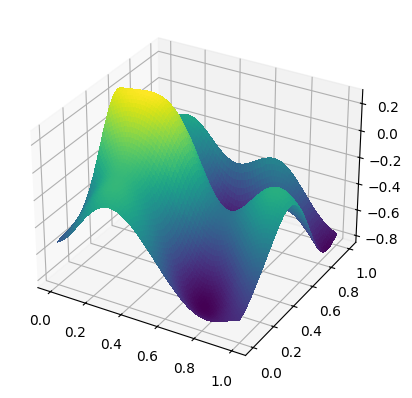

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
V = firedrake.FunctionSpace(mesh, family='CG', degree=2)
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(firedrake.Function(V).interpolate(g), axes=axes);

For basis functions, we'll use polynomials of degree 1.
As we saw in the previous post on hyperbolic conservation laws, these gave very good numerical solutions provided that we had a good timestepping scheme.
Now that we know the polynomial degree and the mesh quality, we can calculate the penalty parameter for Nitsche's method.
We've put in a fudge factor $\alpha$ to make sure the penalty parameter is strictly greater than the minimum possible value.

In [6]:
from firedrake import Constant
p = 1
α = 1/2
C = p * (p + 1)
γ = Constant(2 * C / α**2 / (np.sin(θ) * np.tan(θ/2)))

The action functional for the DG formulation of the problem consists of five parts: an internal cell flux; the across-cell flux; the across-cell penalty; the boundary flux; and the boundary penalty.

In [7]:
from firedrake import inner, grad, dx, ds, dS

Q = firedrake.FunctionSpace(mesh, family='DG', degree=p)
n = firedrake.FacetNormal(mesh)
h = firedrake.CellSize(mesh)

ϕ = firedrake.project(g, Q)
dϕ_dn = inner(grad(ϕ), n)

J_cells = 0.5 * inner(grad(ϕ), grad(ϕ)) * dx
J_facet_flux = -(dϕ_dn('+') - dϕ_dn('-')) * (ϕ('+') - ϕ('-')) * dS
J_facet_penalty = 0.5 * γ / (h('+') + h('-')) * (ϕ('+') - ϕ('-'))**2 * dS

J_flux = -dϕ_dn * (ϕ - g) * ds
J_penalty = 0.5 * γ * (ϕ - g)**2 / h * ds

J = (
    J_cells +
    J_facet_flux +
    J_facet_penalty +
    J_flux +
    J_penalty
)

Finally, we can solve the PDE just like we did before.
Note that, since we're using discontinuous piecewise linear basis functions, there are three degrees of freedom for every triangle of the mesh.
Had we used continuous piecewise linear basis functions, the solution would have one degree of freedom for every vertex, which is much fewer than for the DG basis.
Consequently we can expect the solution process to take much longer when using DG.

In [8]:
F = firedrake.derivative(J, ϕ)
parameters_lu = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
firedrake.solve(F == 0, ϕ, **parameters_lu)

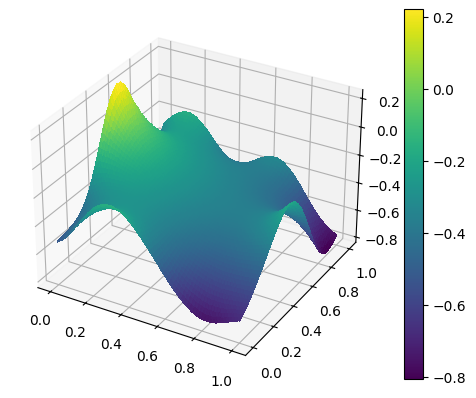

In [9]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
triangles = firedrake.trisurf(ϕ, axes=axes)
fig.colorbar(triangles);

For comparison, we can compute the solution using continuous basis functions.

In [10]:
CG = firedrake.FunctionSpace(mesh, family='CG', degree=p)
ψ = firedrake.Function(CG)
J = 0.5 * inner(grad(ψ), grad(ψ)) * dx

F = firedrake.derivative(J, ψ)
bc = firedrake.DirichletBC(CG, g, 'on_boundary')
firedrake.solve(F == 0, ψ, bc, **parameters_lu)

In [11]:
firedrake.norm(ϕ - ψ) / firedrake.norm(ψ)

np.float64(0.012794504299337386)

The relative error is quite small, which suggests that our approach isn't totally off base.
We're now ready to introduce timestepping, which gets quite interesting for problems of mixed character like ours.

### IMEX methods

The natural way to timestep the heat equation is to use an implicit scheme like backward Euler.
If you did try to use an explicit method, the CFL condition becomes oppressive for parabolic problems because perturbations propagate with infinite speed.
For the advection equation, on the other hand, the natural approach is to use an explicit scheme because perturbations travel with finite speed.
In our case we'll simplify things considerably by assuming the velocity of the medium doesn't change in time, but for realistic problems it too obeys some PDE and we have to assume that it can change.
The argument for using explicit schemes becomes much stronger when the velocity can change because it becomes much harder to reuse information from past implicit solves.

We can reconcile the fact that different timestepping schemes work best for each part of the equation by using a *splitting method*.
The idea of splitting methods is to separately integrate each part of the dynamics with a method that works best for it.
To illustrate this it's helpful to imagine the problems as a linear system of ODE

$$\frac{\partial\phi}{\partial t} = (A + B)\phi$$

where $A$ and $B$ are operators.
The formal solution to this problem can be expressed using the matrix exponential:

$$\phi(t) = e^{t(A + B)}\phi(0)$$

but we're then faced with the challenge of simultaneously integrating both parts of the dynamics.
If $A$ and $B$ commute, then the exponential factors into a product, but we have to get very lucky for that to happen.
Instead, we can recognize that

$$\exp\{t(A + B)\} = \exp(tA)\exp(tB)\exp\left(-\frac{t^2}{2}[A, B]\right)\cdot \ldots$$

In other words, to approximate integrating the problem forward by one timestep, we can first integrate the $A$ dynamics, then the $B$ dynamics.
There is a cost in doing so: we incur a splitting error proportional to the commutator $[A, B]$ of the two operators.
But this error is only of the order of $\delta t^2$ for a single timestep and thus on the order of $\delta t$ over all.
We can derive higher-order splitting schemes that incur even less of a cost, often using the [Zassenhaus](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula#Zassenhaus_formula) formula.
The equation I wrote above is the Zassenhous formula up to second order.

In our particular case, we know that using implicit Euler will work well for the parabolic part of the problem and explicit Euler (with a CFL-stable timestep) will work well for the hyperbolic part.
A first-order splitting scheme amounts to using each scheme in succession.
This approach to mixed-type problems is often called an **implicit/explicit** or **IMEX** discretization in the literature.

### Demonstration

We'll use a very similar setup to the post on conservation laws to examine a simple first-order IMEX scheme for the convection-diffusion equation.
The velocity field will be uniform solid body rotation about the center of the domain.
In order to keep the solution from being immediately smoothed over, we'll use a conductivity coefficient of 1/1000.
This puts the problem well in the advection-dominated regime.
Nonetheless, the diffusivity is large enough that we won't need to use a flux limiter; any spurious oscillations will naturally get smoothed out.

In [12]:
p = 1
Q = firedrake.FunctionSpace(mesh, family='DG', degree=p)

In [13]:
from firedrake import sqrt, as_vector, min_value, max_value

x = firedrake.SpatialCoordinate(mesh)
x_c = Constant((5/8, 5/8))
R_c = Constant(1/8)

x_b = Constant((3/8, 3/8))
R_b = Constant(1/8)

ϕ_expr = (
    max_value(0, 1 - sqrt(inner(x - x_c, x - x_c) / R_c**2)) +
    max_value(0, 1 - inner(x - x_b, x - x_b) / R_b**2)
)
ϕ_0 = firedrake.project(ϕ_expr, Q)
ϕ = ϕ_0.copy(deepcopy=True)

In [14]:
x = firedrake.SpatialCoordinate(mesh)
y = Constant((.5, .5))
r = x - y
u = as_vector((-r[1], r[0]))

In [15]:
speed = firedrake.Function(Q).interpolate(sqrt(inner(u, u)))
max_speed = speed.dat.data_ro.max()

Q0 = firedrake.FunctionSpace(mesh, family='DG', degree=0)
diameters = firedrake.project(firedrake.CellDiameter(mesh), Q0)
min_diameter = diameters.dat.data_ro.min()

cfl_timestep = min_diameter / max_speed

final_time = 2 * π
num_steps = 4 * int(final_time / cfl_timestep)
dt = firedrake.Constant(final_time / num_steps)

First, we'll create a solver for the diffusive part of the problem.
We can take advantage of the fact that the implicit Euler timestep for a parabolic PDE is itself a minimization problem to keep our description as succinct as possible.

In [16]:
J_mass = 0.5 * (ϕ - ϕ_0)**2 * dx

k = Constant(1e-3)
dϕ_dn = inner(grad(ϕ), n)
J_cells = 0.5 * inner(grad(ϕ), grad(ϕ)) * dx
J_facet_flux = -(dϕ_dn('+') - dϕ_dn('-')) * (ϕ('+') - ϕ('-')) * dS
J_facet_penalty = 0.5 * γ / (h('+') + h('-')) * (ϕ('+') - ϕ('-'))**2 * dS

J = J_mass + dt * k * (J_cells + J_facet_flux + J_facet_penalty)

F = firedrake.derivative(J, ϕ)
heat_problem = firedrake.NonlinearVariationalProblem(F, ϕ)
heat_solver = firedrake.NonlinearVariationalSolver(heat_problem, **parameters_lu)

Next we'll create a solver for the convective part of the problem.

In [17]:
from firedrake import min_value, max_value
m = firedrake.TrialFunction(Q) * firedrake.TestFunction(Q) * dx

ψ = firedrake.TestFunction(Q)
cell_flux = -inner(grad(ψ), ϕ * u) * dx

f = ϕ * max_value(0, inner(u, n))
facet_flux = (f('+') - f('-')) * (ψ('+') - ψ('-')) * dS

ϕ_in = firedrake.Constant(0)
influx = ϕ_in * min_value(0, inner(u, n)) * ψ * ds
outflux = ϕ * max_value(0, inner(u, n)) * ψ * ds

dϕ_dt = -(cell_flux + facet_flux + influx + outflux)

In [18]:
δϕ = firedrake.Function(Q)
flow_problem = firedrake.LinearVariationalProblem(m, dt * dϕ_dt, δϕ)
parameters_bjac = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'bjacobi',
        'sub_pc_type': 'ilu'
    }
}
flow_solver = firedrake.LinearVariationalSolver(flow_problem, **parameters_bjac)

Now we can try the alternating scheme.

In [19]:
from tqdm.notebook import trange

output_freq = 4
ϕs = []

for step in trange(num_steps, unit='timesteps'):
    flow_solver.solve()
    ϕ += δϕ

    ϕ_0.assign(ϕ)
    heat_solver.solve()
    
    if step % output_freq == 0:
        ϕs.append(ϕ.copy(deepcopy=True))

  0%|          | 0/396 [00:00<?, ?timesteps/s]

In [20]:
%%capture
fig, axes = plt.subplots()
axes.set_aspect('equal')
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
colors = firedrake.tripcolor(ϕ, num_sample_points=1, vmin=0., vmax=1., axes=axes)

In [21]:
from firedrake.plot import FunctionPlotter
fn_plotter = FunctionPlotter(mesh, num_sample_points=1)

In [22]:
from matplotlib.animation import FuncAnimation
def animate(ϕ):
    colors.set_array(fn_plotter(ϕ))

interval = 1e3 * output_freq * float(dt)
animation = FuncAnimation(fig, animate, frames=ϕs, interval=interval)

In [23]:
from IPython.display import HTML
HTML(animation.to_html5_video())

Unlike in the purely hyperbolic case, the solution becomes much smoother by the time the medium has completed a full rotation.
If we had used an even smaller conductivity coefficient $k$, the intrinsic diffusion in the problem would be too small to suppress the oscillations that we would get for a purely convective problem using degree-1 basis functions.
In that case a flux limiter would be necessary to get a decent solution.

### Conclusion

The natural choices to make about spatial and temporal discretization for parabolic and hyperbolic problems are complete opposites.
To solve a PDE that combines aspects of both types, finding a good middle ground can be a challenge.
Here we showed that non-conforming discretizations of elliptic PDE allow us to apply what we already know about DG discretizations of conservation laws to other problems.

For time discretization, operator splitting helps turn a harder problem into two easy ones.
In this post we only showed a first-order splitting scheme, but [Strang splitting](https://en.wikipedia.org/wiki/Strang_splitting) achieves second-order accuracy with only a little more work.
Operator splitting is a great trick generally but achieving more than first-order accuracy for more than three operators or more is much harder than for two.